In [36]:
import os, sys
import pytorch_lightning as pl
import torch
from rdkit import Chem
import numpy as np
import rdkit.Chem.Descriptors
from IPython.display import Image, display
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
import torch_geometric
from IPython.display import Markdown as md

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
if "../../.." not in sys.path:
    sys.path.append("../../..")

In [3]:
DEFAULT_DPI=300
DEFAULT_IMG_PLOT_WIDTH=400
SEED=2
TEST_SMILES="COc1ccc([N+](=O)[O-])cc1"
DEFAULT_PATIENCE=5

In [4]:
def plot_true_pred(model,loader,target_file=None):
    true=[]
    pred=[]
    for i,d in enumerate(loader.test_dataloader()):
        pred.extend(model(d.to(model.device)).detach().cpu().numpy()[:,0])
        true.extend(d.y.detach().cpu().numpy()[:,0])
        
        
    plt.plot(true,pred,"o")
    if target_file is None:
        plt.show()
    else:
        os.makedirs(os.path.dirname(target_file),exist_ok=True)
        plt.savefig(target_file,dpi=DEFAULT_DPI)
    plt.close()

In [5]:
from IPython.display import clear_output
class ClearCallback(pl.Callback):
    def on_epoch_end(self,*args,**kwargs):
        self.clear()
    
    def clear(self):
        clear_output(wait=True)
    
class StoreMetricsCallback(pl.Callback):
    def __init__(self,live_plot=True,final_save=None,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.data={}
        self.live_plot=live_plot
        self.final_save=final_save
    
    def plot_data(self,save=None):
        plt.figure()
        for label,data in self.data.items():
            plt.plot(data[0],data[1], label=label)
        plt.legend()
        if save:
            plt.savefig(save,dpi=DEFAULT_DPI)
        else:
            plt.show()
        plt.close()
        
    def on_validation_epoch_end(self,trainer, pl_module,*args,**kwargs):
        ep=trainer.current_epoch
        for k,v in trainer.callback_metrics.items():
            if k not in self.data:
                self.data[k]=([],[])
            self.data[k][0].append(ep)
            self.data[k][1].append(v.detach().cpu().numpy())
        if self.live_plot:
            self.plot_data()
            
            

    #on_validation_epoch_end = on_epoch_end
    #on_test_epoch_end = on_epoch_end
    #on_train_epoch_end = on_epoch_end
    
    def on_train_end(self,trainer, pl_module):
        self.plot_data(self.final_save)

In [6]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

def default_model_run(model_name,model,loader,force_run=False,detect_lr=True,show_tb=True,
                      train=True,save=True,test=True,live_plot=True,max_epochs=1000,min_epochs=1):
    model_dir=os.path.join("models",model_name)

    logdir=os.path.join(model_dir,"logs")
    tb_logdir=os.path.join(logdir,"tensorboard")
    plot_dir=os.path.join(model_dir,"plots")
    
    os.makedirs(plot_dir,exist_ok=True)
    true_pred_plt=os.path.join(plot_dir,"tvp.png")
    lr_optim_plot=os.path.join(plot_dir,"lrp.png")
    metrics_plot=os.path.join(plot_dir,"metrics.png")
    
    model_checkpoint=os.path.join(model_dir,"model.ckpt")
    
    if not force_run:
        try:
            model = model.__class__.load_from_checkpoint(model_checkpoint,map_location=lambda storage, location: storage)
        except:
            force_run=True
    
    if force_run:
        
        loader.setup()
        
        if detect_lr:
            lr_trainer = pl.Trainer()
            lr_finder = lr_trainer.tuner.lr_find(model,train_dataloader=loader.train_dataloader(),max_lr=10**2)
            fig = lr_finder.plot(suggest=True)
            
            plt.savefig(lr_optim_plot,dpi=DEFAULT_DPI)
            plt.close()
            # Pick point based on plot, or get suggestion
            model.lr = lr_finder.suggestion()
            print("set lr to",model.lr)
    
        if train or test:
            clear_cb=ClearCallback()
            tb_logger = TensorBoardLogger(tb_logdir)
            checkpoint_callback = ModelCheckpoint(monitor='val_loss')
            metrics_cb = StoreMetricsCallback(live_plot=live_plot,
                                 final_save=metrics_plot,
                                 )
            trainer = pl.Trainer(max_epochs=max_epochs,gpus=torch.cuda.device_count(),
                                callbacks=[
                                    clear_cb,
                                    pl.callbacks.early_stopping.EarlyStopping(monitor='val_loss',patience=DEFAULT_PATIENCE),
                                    metrics_cb,
                                    checkpoint_callback,
                                ],
                                logger=tb_logger,
                                terminate_on_nan=True,
                                 min_epochs=min_epochs,
                                )

        if train:
            trainer.fit(model,loader)
            model = model.__class__.load_from_checkpoint(checkpoint_callback.best_model_path)
            
        if test:
            trainer.test(model=model,ckpt_path=None)
            
        if save:
            trainer.save_checkpoint(model_checkpoint)

        model.to('cpu')
        plot_true_pred(model,loader,target_file=true_pred_plt)
    
    if os.path.exists(lr_optim_plot):
        display(Image(lr_optim_plot, width=DEFAULT_IMG_PLOT_WIDTH))
    if os.path.exists(metrics_plot):
        display(Image(metrics_plot, width=DEFAULT_IMG_PLOT_WIDTH))
    if os.path.exists(true_pred_plt):
        display(Image(true_pred_plt, width=DEFAULT_IMG_PLOT_WIDTH))
    
    data={}
    try:
        data["trainer"]=trainer
    except:
        pass
    return model,data

In [7]:
def find_test_data(loader,smiles=None):
    if smiles is None:
        smiles = TEST_SMILES
    loader.setup()
    for subloader in [loader.test_dataloader(),loader.val_dataloader(),loader.train_dataloader()]:
        for i,d in enumerate(subloader):
            for sd in d.to_data_list():
                if smiles == sd.string_data[0][sd.string_data_titles[0].index("smiles")]:
                    return sd
    raise ValueError()

                

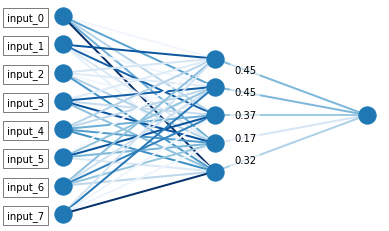

In [192]:
import networkx as nx
def plot_fcnn(layer_sizes,weights=None, biases=False,show_bar=False,input_labels=None,weight_position=None,round_weights=2,edge_width=1):
    g=nx.Graph()
    pos={}
    w=0
    if weights is not None:
        weights=np.round(weights,round_weights)
        needed_w = sum([layer_sizes[i]*layer_sizes[i+1] for i in range(len(layer_sizes)-1)])
        assert len(weights)==needed_w, (len(weights),needed_w)
    
    for l,n in enumerate(layer_sizes):
        for i in range(n):
            node="{}_{}".format(l,i)
            node_d={}
            if l==0:
                if input_labels is not None:
                    node_d["label"]=input_labels[i]
            g.add_node(node,**node_d)
            pos[node]=(l*50,-(i-n/2)*10)
            if l>0:
                for j in range(layer_sizes[l-1]):
                    pnode="{}_{}".format(l-1,j)
                    ed={}
                    if weights is not None:
                        ed["w"]=weights[w]
                        w+=1
                    g.add_edge(pnode,node,**ed)
            
    
    fig = plt.figure()
    
    nodes = nx.draw_networkx_nodes(
            g, pos
        )
    if input_labels:
        for i,(node,data) in enumerate(g.nodes(data=True)):
            if node.startswith("0_"):
                x,y=pos[node]
                plt.text(x-6,y,s=data["label"], bbox=dict(facecolor='white', alpha=0.5),horizontalalignment='right',verticalalignment="center_baseline")
            
    ed={'width':edge_width}
    if weights is not None:
        cmap=plt.cm.Blues
        vmin = 0
        vmax=weights.max()
        ed={**ed,**dict(edge_cmap= cmap,
                edge_color=[np.abs(v["w"]) for n1,n2,v in g.edges(data=True)],
                edge_vmin = vmin,
                edge_vmax = vmax,
               )
           }
        
        if weight_position is not None:
            def draw_networkx_edge_labels(edge_labels,label_pos):
                nodes = nx.draw_networkx_edge_labels(
                            g, pos,
                            edge_labels=edge_labels,
                            rotate=False,
                            label_pos=label_pos,
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
                        )
                
            if isinstance(weight_position,(float,int)):
                edge_labels={(n1,n2):v["w"] for n1,n2,v in g.edges(data=True)}
                label_pos = 1-weight_position
                draw_networkx_edge_labels(edge_labels,label_pos)
            else:
                assert len(weight_position) == len(layer_sizes)-1
                for i,wp in enumerate(weight_position):
                    if wp is None:
                        continue
                    if isinstance(wp,(float,int)):
                        edge_labels={}
                        for n1,n2,v in g.edges(data=True):
                            if n1.startswith("{}_".format(i)):
                                edge_labels[(n1,n2)]=v["w"]
                        nodes = draw_networkx_edge_labels(
                            edge_labels=edge_labels,
                            label_pos=1-wp,
                        )
                        
        if show_bar:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
            plt.colorbar(sm)
    
    edges = nx.draw_networkx_edges(g, pos,**ed)

    #plt.tight_layout
    plt.axis('off')
    plt.show()
    plt.close()
    
plot_fcnn([8,5,1],np.random.random(45),input_labels=["input_{}".format(i) for i in range(8)],weight_position=[None,0.2],edge_width=2)

In [15]:
#first a blank mol dataset
#from molNet.dataloader.datasets import DelaneySolubility
#dataset=DelaneySolubility().df
import pandas as pd
dataset = pd.read_csv("list_chemicals-2020-12-05-21-46-06.tsv",sep="\t")

TEST_SMILES=Chem.MolToSmiles(Chem.MolFromSmiles(TEST_SMILES))
dataset = dataset.append({
    'SMILES':"C",
    'PREFERRED_NAME':"Methane"
},ignore_index=True)
dataset["rd_mol"] = dataset['SMILES'].apply(lambda s: Chem.MolFromSmiles(s))
no_mols = dataset.index[~dataset["rd_mol"].apply(lambda x: isinstance(x,Chem.Mol))]
dataset.drop(no_mols,inplace=True)
dataset["SMILES"] = dataset['rd_mol'].apply(lambda s: Chem.MolToSmiles(s))
dataset["molar_mass"] = dataset['rd_mol'].apply(lambda mol: Chem.Descriptors.MolWt(mol))
dataset = dataset.rename({'PREFERRED_NAME':'name'},axis=1)

from molNet.featurizer.atom_featurizer import atom_symbol_one_hot_from_set
c_atom_symbol_featurizer = atom_symbol_one_hot_from_set(dataset["rd_mol"],only_mass=True)
dataset
c_atom_symbol_featurizer.describe_features()
#for i,data in dataset.iterrows():
#    for atom in data["rd_mol"].GetAtoms():
#        if atom.GetSymbol()=="*":
#            display(data["rd_mol"])
#            display(data)
            break

,DTXSID,name,CASRN,INCHIKEY,IUPAC_NAME,SMILES,INCHI_STRING,MOLECULAR_FORMULA,AVERAGE_MASS,MONOISOTOPIC_MASS,DATA_SOURCES,NUMBER_OF_PUBMED_ARTICLES,PUBCHEM_DATA_SOURCES,CPDAT_COUNT,rd_mol,molar_mass
0,DTXSID7020009,Acetonitrile,75-05-8,WEVYAHXRMPXWCK-UHFFFAOYSA-N,Acetonitrile,CC#N,InChI=1S/C2H3N/c1-2-3/h1H3,C2H3N,41.053,41.026549101,165.0,3174.0,1110,318,"<img data-content=""rdkit/molecule"" src=""data:i...",41.053
1,DTXSID5020023,Acrolein,107-02-8,HGINCPLSRVDWNT-UHFFFAOYSA-N,Prop-2-enal,C=CC=O,"InChI=1S/C3H4O/c1-2-3-4/h2-3H,1H2",C3H4O,56.064,56.026214749,189.0,2468.0,139,30,"<img data-content=""rdkit/molecule"" src=""data:i...",56.064
2,DTXSID0020024,Acrolein diethylacetal,3054-95-3,MCIPQLOKVXSHTD-UHFFFAOYSA-N,"3,3-Diethoxyprop-1-ene",C=CC(OCC)OCC,"InChI=1S/C7H14O2/c1-4-7(8-5-2)9-6-3/h4,7H,1,5-...",C7H14O2,130.187,130.099379691,45.0,1.0,100,-,"<img data-content=""rdkit/molecule"" src=""data:i...",130.187
3,DTXSID5020029,Acrylonitrile,107-13-1,NLHHRLWOUZZQLW-UHFFFAOYSA-N,Prop-2-enenitrile,C=CC#N,"InChI=1S/C3H3N/c1-2-3-4/h2H,1H2",C3H3N,53.064,53.026549101,195.0,1092.0,168,582,"<img data-content=""rdkit/molecule"" src=""data:i...",53.064
4,DTXSID8020044,Allyl alcohol,107-18-6,XXROGKLTLUQVRX-UHFFFAOYSA-N,Prop-2-en-1-ol,C=CCO,"InChI=1S/C3H6O/c1-2-3-4/h2,4H,1,3H2",C3H6O,58.08,58.041864813,153.0,627.0,152,2,"<img data-content=""rdkit/molecule"" src=""data:i...",58.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3851,DTXSID30996806,(6-Methylheptan-2-yl)hydrazine,7535-34-4,WAYKZORTCXXXDO-UHFFFAOYNA-N,(6-Methylheptan-2-yl)hydrazine,CC(C)CCCC(C)NN,"InChI=1/C8H20N2/c1-7(2)5-4-6-8(3)10-9/h7-8,10H...",C8H20N2,144.262,144.162648652,6.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",144.262
3852,DTXSID10998848,2-Chlorooxirane,7763-77-1,WBNCHVFLFSFIGK-UHFFFAOYNA-N,2-Chlorooxirane,ClC1CO1,"InChI=1/C2H3ClO/c3-2-1-4-2/h2H,1H2",C2H3ClO,78.5,77.9872424,6.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",78.498
3853,DTXSID20999144,2-[(Butan-2-yl)oxy]ethan-1-ol,7795-91-7,HUWFDQSAXOIUNP-UHFFFAOYNA-N,2-[(Butan-2-yl)oxy]ethan-1-ol,CCC(C)OCCO,"InChI=1/C6H14O2/c1-3-6(2)8-5-4-7/h6-7H,3-5H2,1...",C6H14O2,118.176,118.099379691,11.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",118.176
3854,DTXSID70999775,2-Methyl-1-[(propan-2-yl)oxy]propane,78448-33-6,HIIBZFKVMXEQMR-UHFFFAOYSA-N,2-Methyl-1-[(propan-2-yl)oxy]propane,CC(C)COC(C)C,"InChI=1S/C7H16O/c1-6(2)5-8-7(3)4/h6-7H,5H2,1-4H3",C7H16O,116.204,116.120115135,3.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",116.204


In [37]:
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds, CalcExactMolWt, CalcNumLipinskiHBD, CalcNumRings, \
    CalcNumLipinskiHBA, CalcNumHBA, CalcNumHBD, CalcNumAromaticRings, CalcNumSaturatedRings, CalcNumHeterocycles, \
    CalcNumAromaticHeterocycles, CalcNumAromaticCarbocycles, CalcNumSaturatedHeterocycles, CalcNumSaturatedCarbocycles, \
    CalcNumAliphaticRings, CalcNumAliphaticHeterocycles, CalcNumAliphaticCarbocycles, CalcNumHeteroatoms, \
    CalcNumAmideBonds, CalcFractionCSP3, CalcLabuteASA, CalcTPSA, CalcChi0v, CalcChi1v, CalcChi2v, CalcChi3v, CalcChi4v, \
    CalcChi0n, CalcChi1n, CalcChi2n, CalcChi3n, CalcChi4n, CalcHallKierAlpha, CalcKappa1, CalcKappa2, CalcKappa3, \
    CalcNumSpiroAtoms, CalcNumBridgeheadAtoms, CalcNumAtomStereoCenters, CalcNumUnspecifiedAtomStereoCenters, CalcPBF, \
    CalcNPR1, CalcNPR2, CalcPMI1, CalcPMI2, CalcPMI3, CalcRadiusOfGyration, CalcInertialShapeFactor, CalcEccentricity, \
    CalcAsphericity, CalcSpherocityIndex, CalcCrippenDescriptors, GetUSR, GetUSRCAT, SlogP_VSA_, SMR_VSA_, PEOE_VSA_, \
    CalcWHIM, CalcGETAWAY, CalcRDF, CalcMORSE, CalcAUTOCORR3D, CalcAUTOCORR2D
sdf=dataset.copy()

sdf=sdf[sdf.rd_mol.apply(lambda mol: CalcNumAromaticRings(mol)>0)]
patern=Chem.MolFromSmarts('[N+]([O-])=O')
sdf=sdf[sdf.rd_mol.apply(lambda mol: mol.HasSubstructMatch(patern))]
patern=Chem.MolFromSmarts('cOC')
sdf=sdf[sdf.rd_mol.apply(lambda mol: mol.HasSubstructMatch(patern))]
m =sdf.iloc[0].rd_mol

TEST_SMILES=Chem.MolToSmiles(sdf.sort_values("molar_mass",axis=0).rd_mol.iloc[0])

First we start with a simple example by predicting the molar masses of random molecules (**maybe library for creating pseudo random molecules**). As a featurization the mass of each individual atom was used. As a resultto get the molar mass of each respective molecule all features (individual atomic masses) have to be added. 
The process to sum all features together is basically one possibillity for a pooling operation. pooling is usally done at the end of a graph convolution to bring an arbitary shaped graph to an fixed size vecor.
Basic pooling operation are operations to calculate scalar parameters like location parameter (*e.g*.minimum, maximm average) or the sum over every dimension of the final features of the graph. This results in a vector of a size equal to the number if final features, which is a fixed hyperparameter for the models.
$$f=\Theta(f_0,f_1,...f_{N})$$

If we just perform a simple sum pooling over the inital graph features without any graph convolution or what so ever, there are no trainable parameters in the model and thus training is not necessary (nor possible):

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


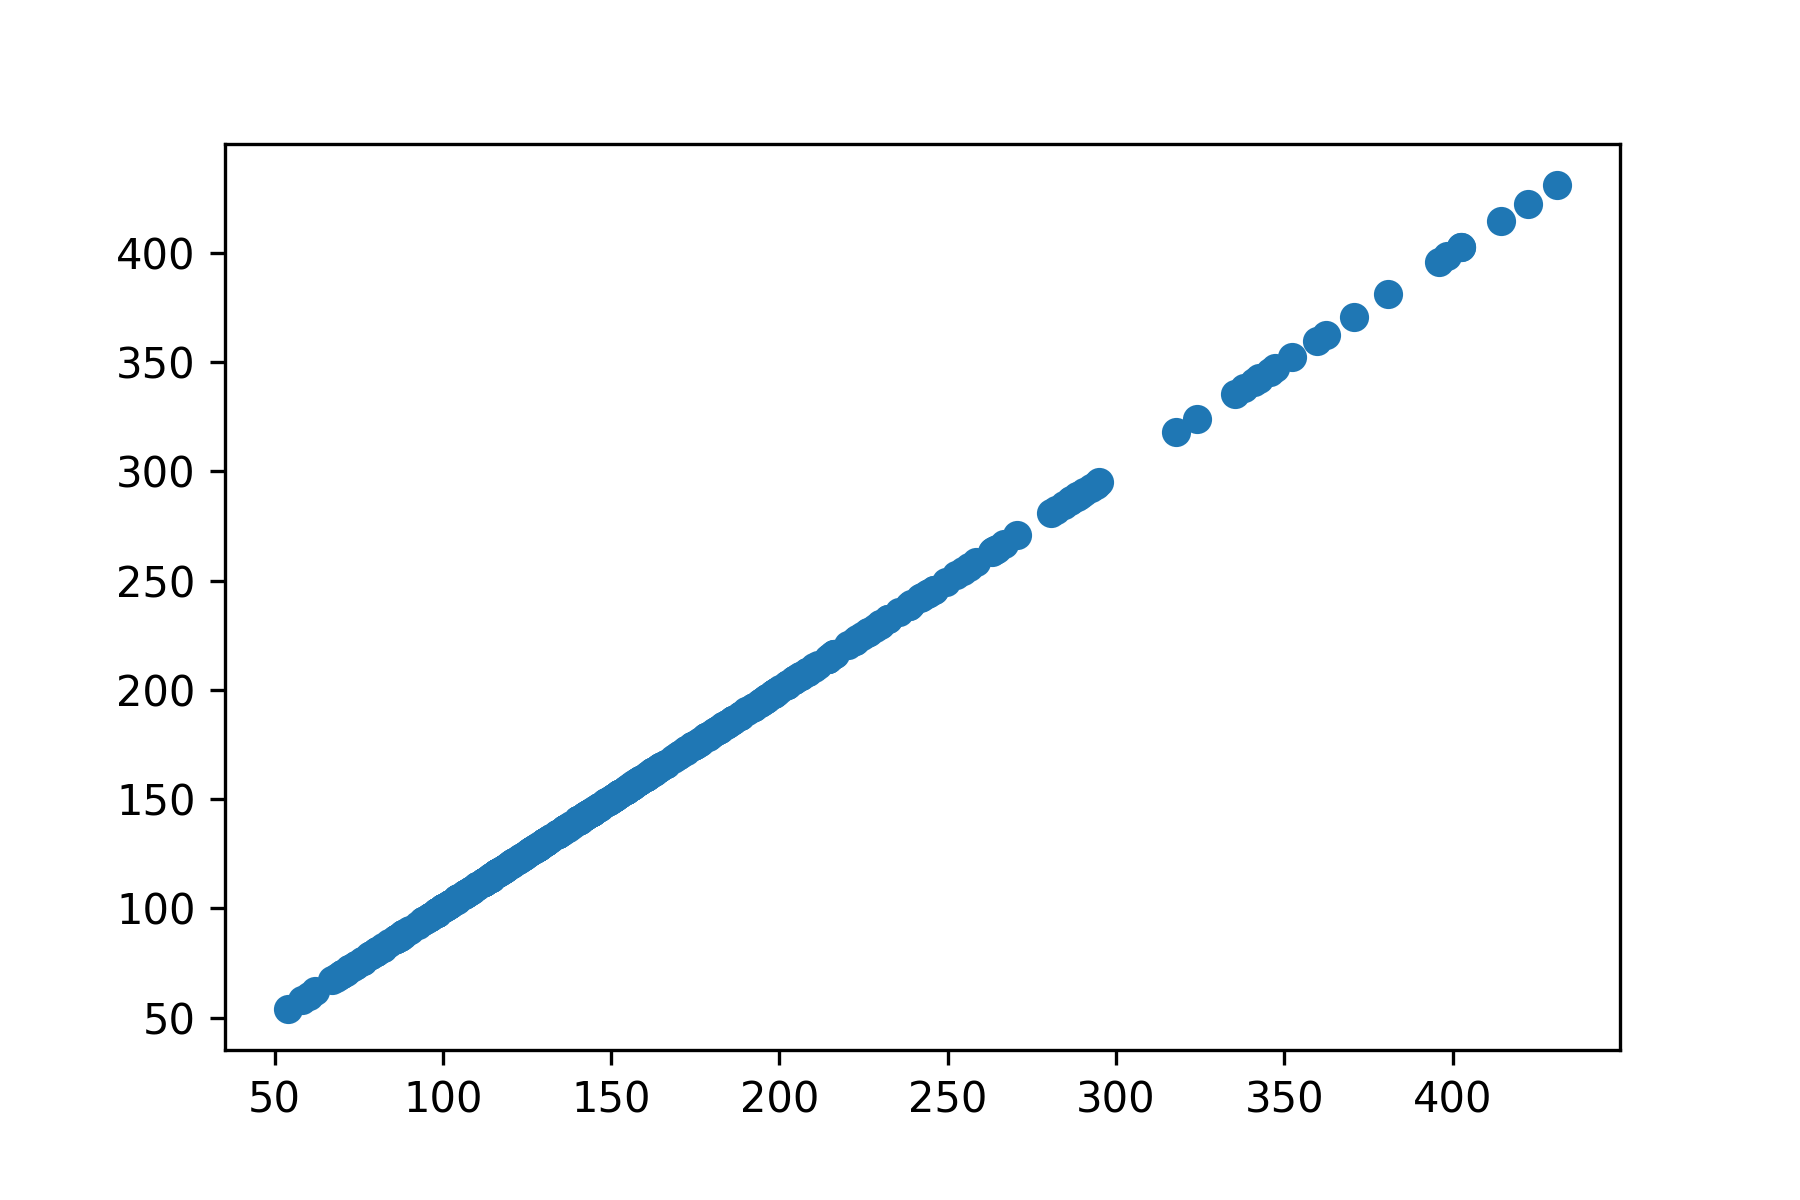

In [11]:
# noinspection JupyterPackage
from molNet.nn.models.graph_convolution import PoolSum
from molNet.dataloader.molecule_loader import PytorchGeomMolGraphFromGeneratorLoader, PytorchGeomMolGraphGenerator, PytorchGeomMolGraphFromDfLoader
from molNet.featurizer.atom_featurizer import atom_mass

class SimpleSumAtomMassesModel(pl.LightningModule):
    def __init__(self,name="none"):
        super().__init__()
        self.save_hyperparameters()
        self.pooling =PoolSum()

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats = self.pooling(feats, batch)
        return feats*100

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)
        

# no parameter and thus no training necessary
model = SimpleSumAtomMassesModel()
#dataloader=DelaneySolubility().to_pytorchgeo_molgraph_generator(
#    to_graph_params = dict(with_properties=True,atom_featurizer=atom_mass,with_mol_graph=True),
#    generator_params={"shuffle":False}
#)

#loader = PytorchGeomMolGraphFromGeneratorLoader(
#    *dataloader,
#    batch_size=1)


loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                         y_properties=["molar_mass"],
                                         seed=SEED,
                                         to_graph_params={"atom_featurizer":atom_mass,"with_mol_graph":True},
                                        batch_size=32
                                        )

model,data = default_model_run(
    "SimpleSumAtomMassesModel",
    model,
    loader,
    force_run=False,
    detect_lr=False,
    show_tb=False,
    train=False,
    save=False,
)
test_data=find_test_data(loader)

As can be seen the model performs perfectly, which is expected since the result of the pooling has matches the real mass of the underlying molecule

If the featurizer is replaced with an atom type featurizer simple pooling cannot be applied any more. Nontheless graph convolution is still not necessary since the most basic approch is to somehow get the mass of each atom and then just apply the sum as in the previous example.

One possibility to to so is by using a weighted sum, where each summand is multiplied with a trainable parameter before summation:
$$f=\sum_{i=0}^{N}{w_i*f_i}$$

From a machine learning perspective this is the same as a one of the simplest fully connected neuronal networks with no hidden layers, no bias and only a single output value:

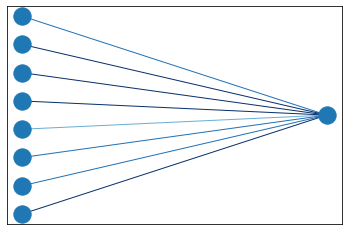

In [33]:
plot_fcnn([8,1],np.random.randint(4,10,8)/10,show_bar=False)

In [42]:
display(md("Now the model contains as many trainable parameters as there are initial features ({})".format(len(c_atom_symbol_featurizer))))

Now the model contains as many trainable parameters as there are initial features (11)

where each feature describes whether the atom that is featurized is one of the following atoms (0 or 1):

In [45]:
[f.replace("custom_atom_symbol_one_hot: ","").replace("None","other") for f in c_atom_symbol_featurizer.describe_features()]

['Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'other']

A carbon atom whould thus be represented by the feature vector:

In [50]:
np.array(c_atom_symbol_featurizer(Chem.Atom("C")))*1

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

It only takes a few epochs (iterations over the training data) for the model to completly tune the weights of the weighted-sum-network, resulting in a nearly perfect prediction. ()

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a test_step but have no test_dataloader. Skipping test loop
  warnings.warn(*args, **kwargs)


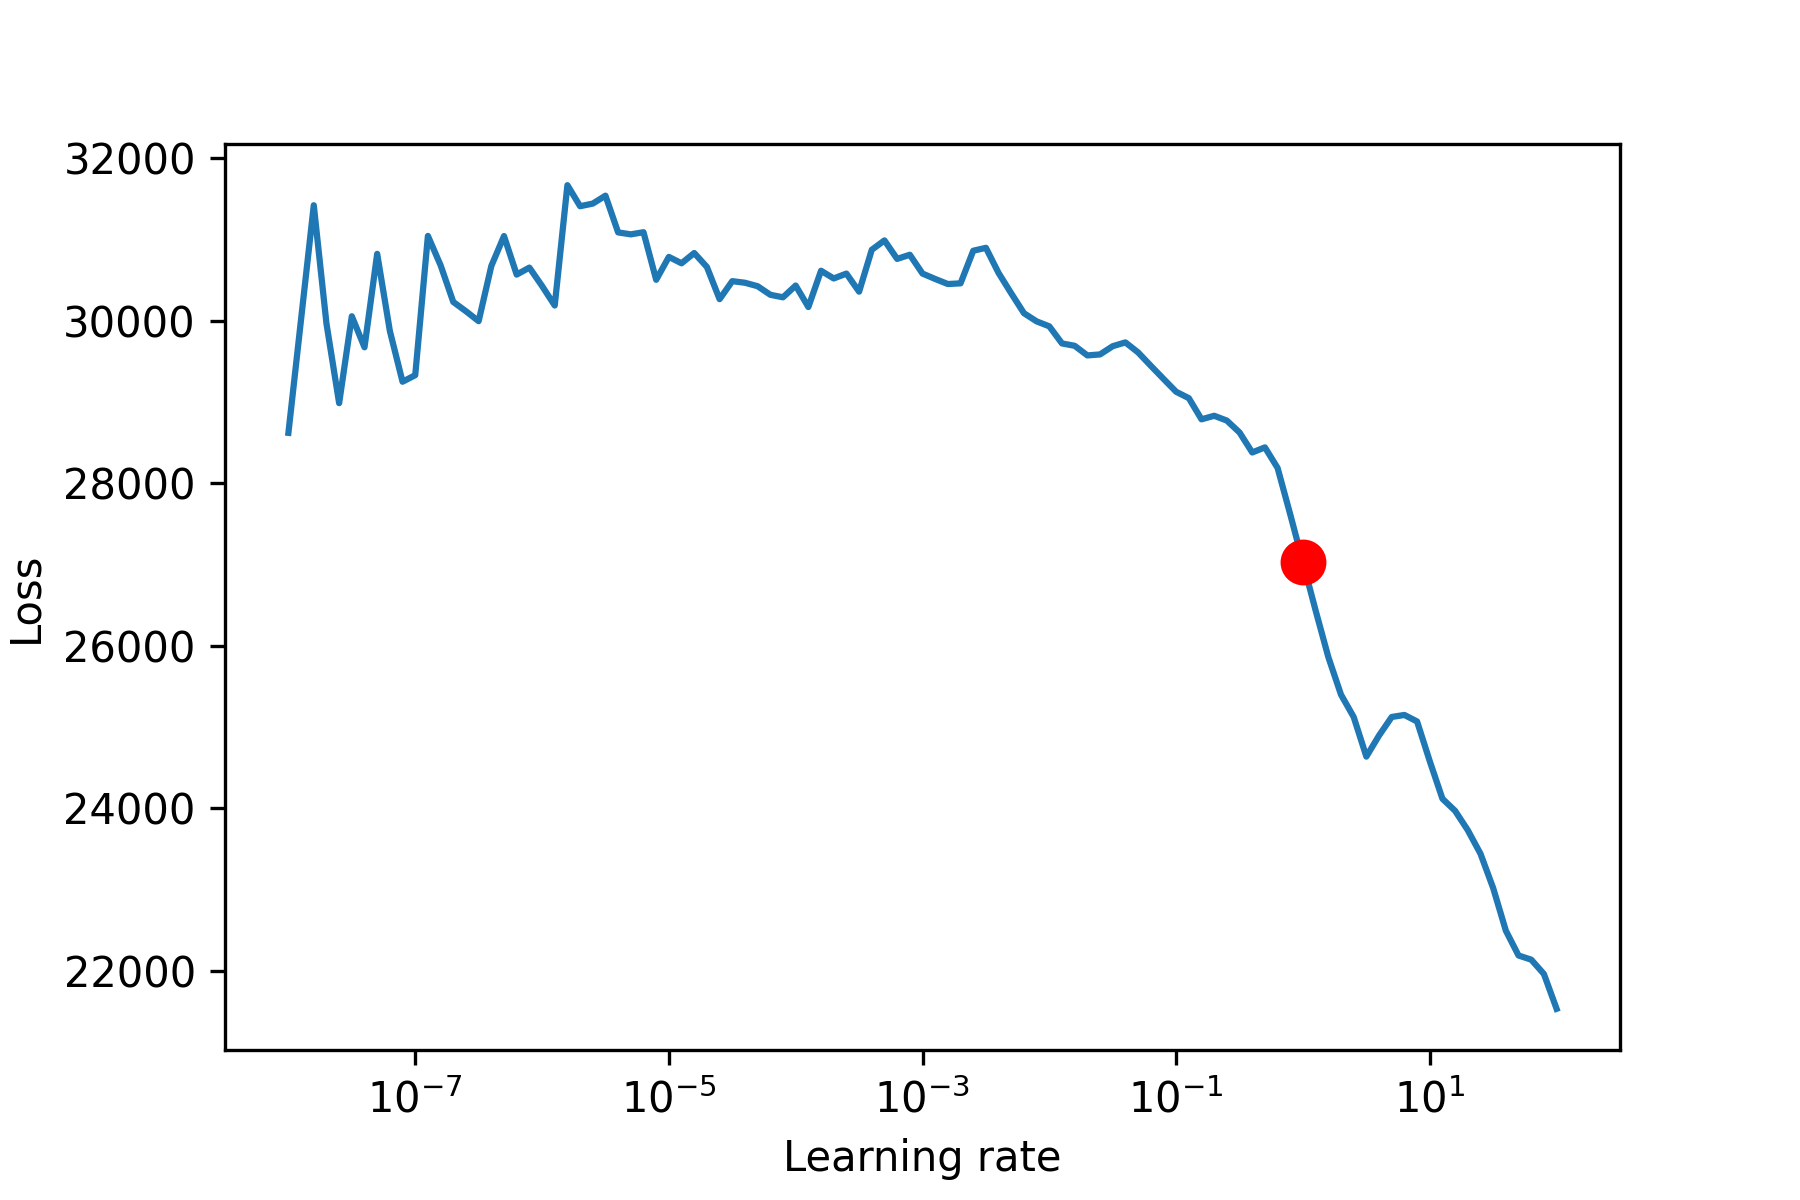

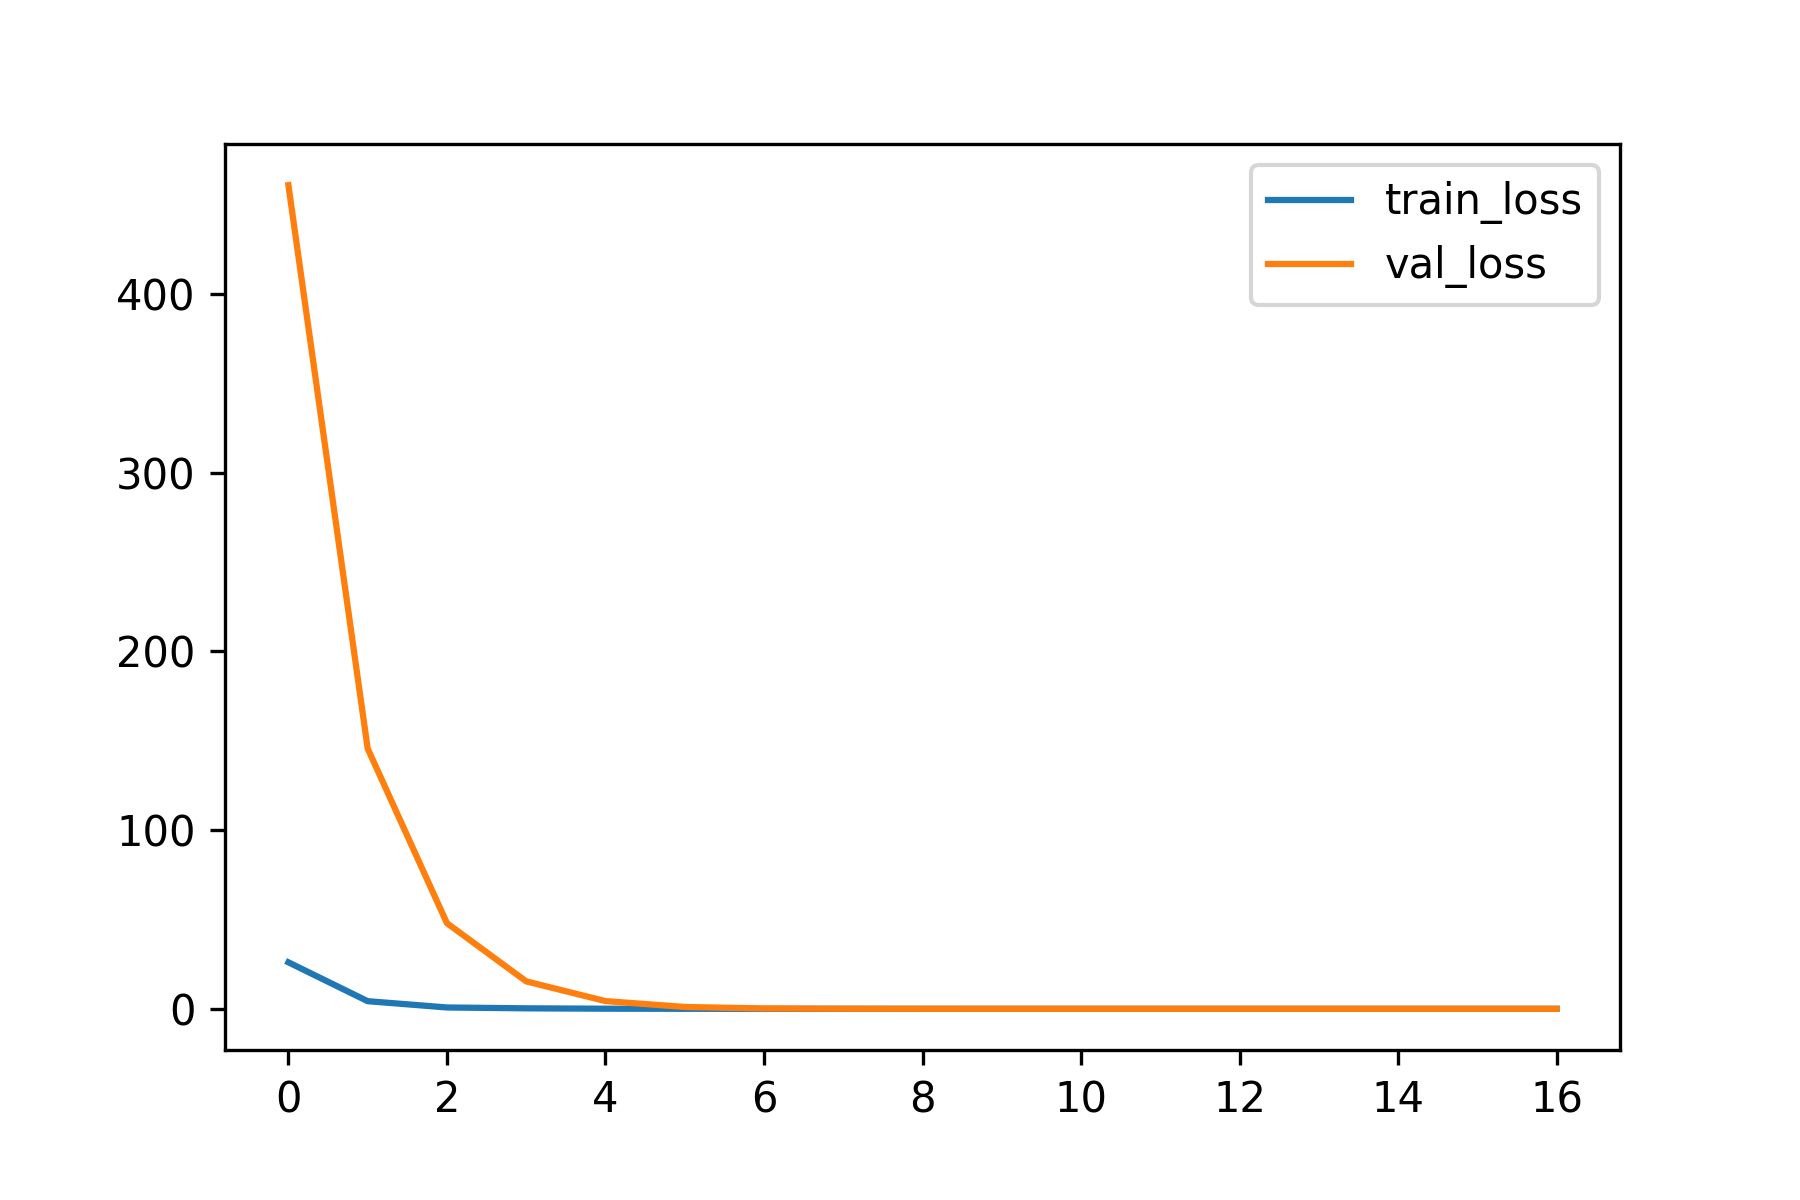

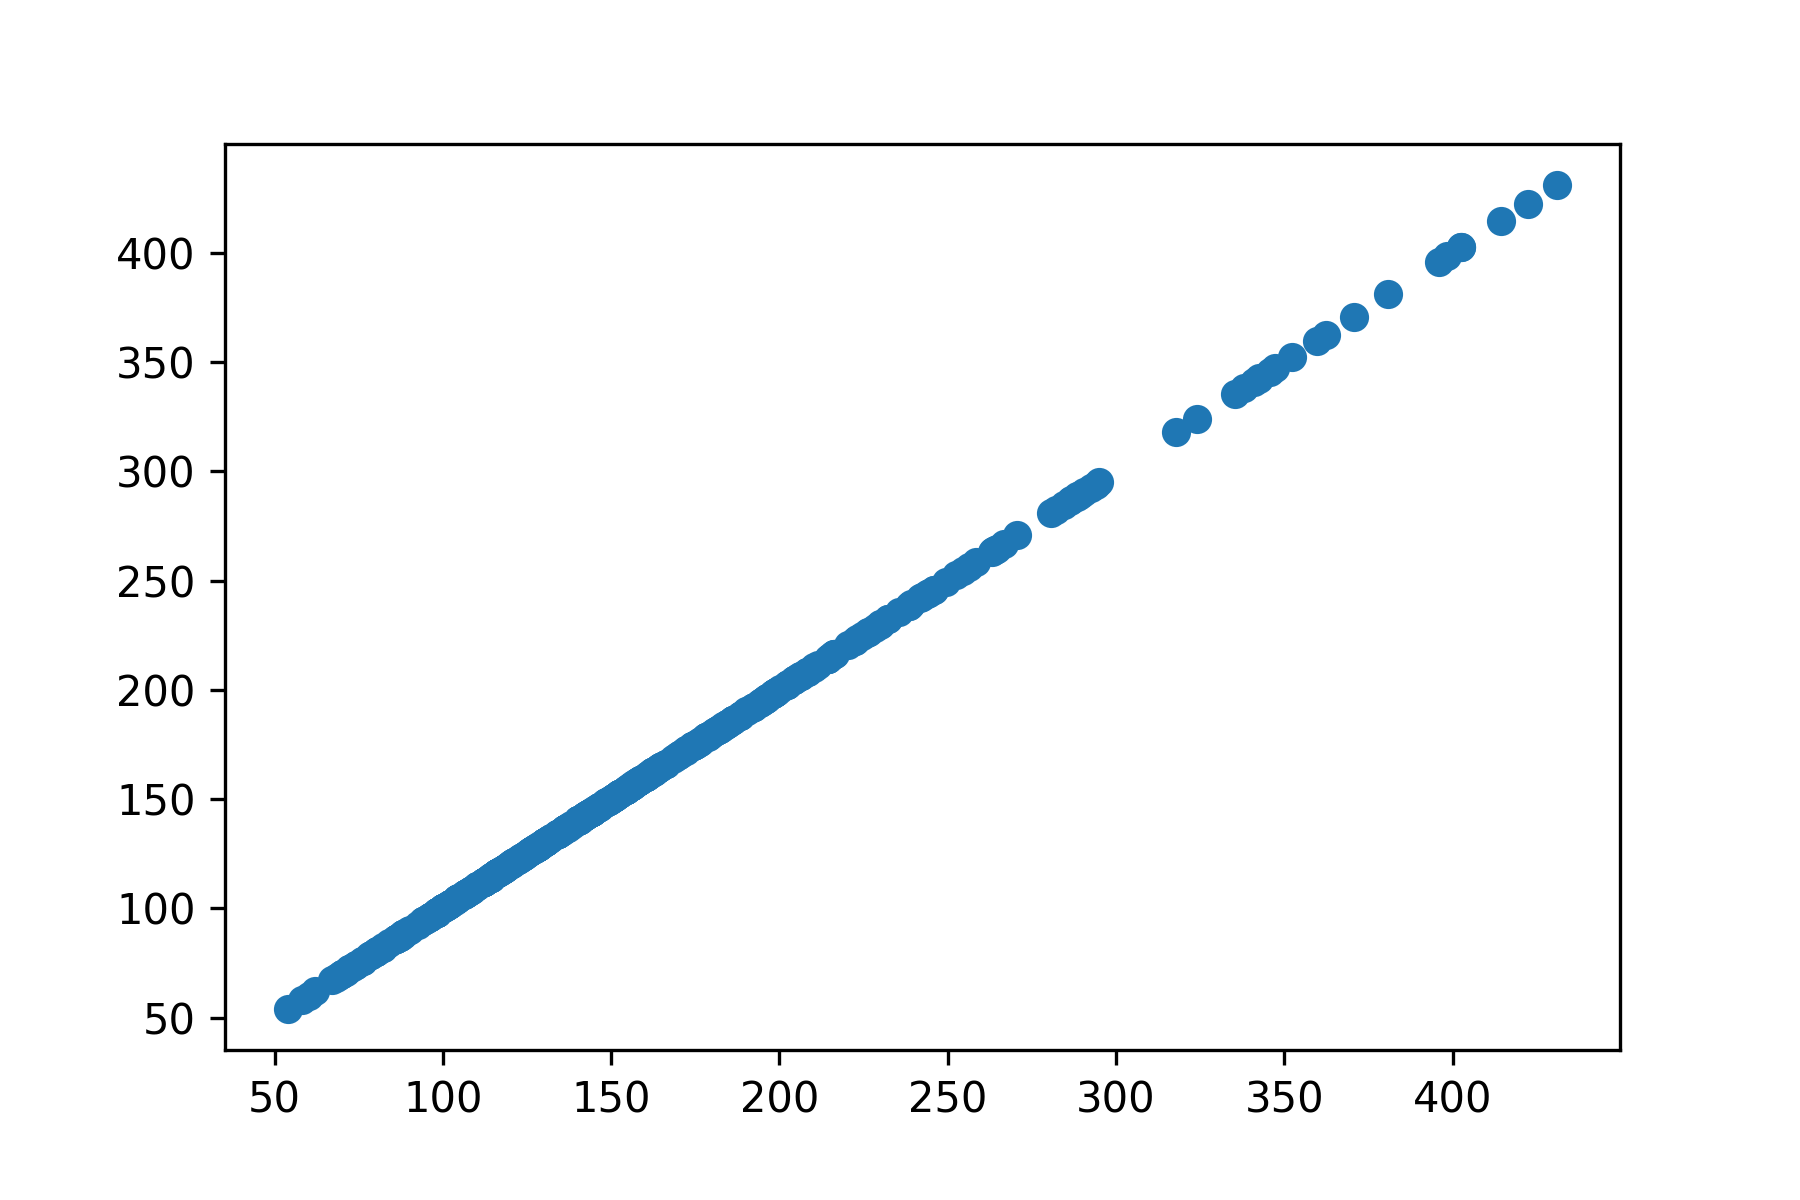

In [19]:
from molNet.featurizer.atom_featurizer import atom_symbol_one_hot
from torch_geometric.nn import GCNConv, GlobalAttention,global_add_pool
from molNet.nn.models.graph_convolution import PoolWeightedSum, PoolSum
import torch.nn.functional as F
import molNet.nn.functional as mF


class MolWeigtFromTypeModel(pl.LightningModule):
    def __init__(self,in_size,name="none"):
        super().__init__()
        self.save_hyperparameters()
        #self.gcn = GCNConv(in_channels=in_size,out_channels=1,bias=False)
        #gate_nn=torch.nn.Linear(in_size,1)
        self.pool_nn=torch.nn.Linear(in_size,1,bias=False)
        self.pooling =PoolWeightedSum(1)
        self.lr = 1e-1

    def unpacked_forward(self, feats, edges, batch,graph_features):
        #feats = self.gcn(feats, edges)
        #display(feats.shape,batch.shape)
        feats= self.pool_nn(feats)
        #display(feats.shape)
        feats = self.pooling(feats, batch)
        return feats

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('test_loss', loss)
        return loss
            
loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                     y_properties=["molar_mass"],
                                     seed=2,
                                     to_graph_params={"atom_featurizer":c_atom_symbol_featurizer,"with_mol_graph":True},
                                    batch_size=32,#num_workers=4
                                    )
model = MolWeigtFromTypeModel(in_size=len(c_atom_symbol_featurizer))

model,data = default_model_run("MolWeigtFromTypeModel",model,loader,
                  force_run=True,#min_epochs=15
                
                 )


test_data=find_test_data(loader)
test_batch=iter(torch_geometric.data.DataLoader([test_data])).next()
#model.gcn(test_batch.x,test_batch.edge_index)
#model()

sample molecule:

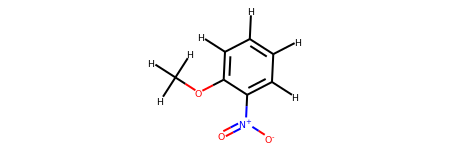

true (calculated) mass: 153.13699340820312 and predicted mass 153.13758850097656

true masses on each atom:

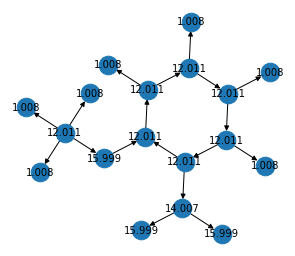

predicted masses on each atom:

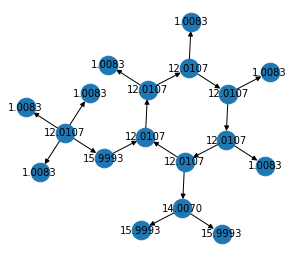

In [57]:
from rdkit.Chem.Draw import SimilarityMaps
display(md("sample molecule:"))
display(test_data.mol_graph.mol)
''
#model.gcn.cached=True
prec=4

display(md("true (calculated) mass: {} and predicted mass {}".format(test_data.y[0][0],model(test_batch)[0][0])))
target_graph = [atom.GetMass() for atom in test_data.mol_graph.mol.GetAtoms()]
l = [np.format_float_positional(c,precision=prec) for c in target_graph]
display(md("true masses on each atom:"))
display(Image(test_data.mol_graph.get_png(labels=l)))

conv = test_batch.x.detach().numpy()#.flatten()
conv=np.argmax(conv,axis=1)
conv = model.pool_nn.weight[0][conv].detach().numpy()
display(md("predicted masses on each atom:"))
l = [np.format_float_positional(c,precision=prec) for c in conv]
display(Image(test_data.mol_graph.get_png(labels=l)))

As can be seen the atomic mass prediction is quite good and correct up o the third decimal place. The difference will become smaller if trained for mor epochs but at some point the gain will be dimishing small.
If we take a closer look at the weights from the weight-sum-network, it becomes clear, that the weights simply became tuned to the individual masses of the atom types and thus the output becomes the mass of the aotom whos featuer vector was feed into the network (note that other is a placeholder for all atoic symbols not in the feature vector, if none are present it's value is random):

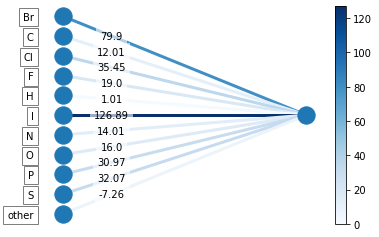

In [195]:
plot_fcnn([11,1],model.pool_nn.weight[0].detach().numpy() ,show_bar=True,input_labels=[f.replace("custom_atom_symbol_one_hot: ","").replace("None","other") for f in c_atom_symbol_featurizer.describe_features()],weight_position=0.2,edge_width=3)

Up until know we've only dealt with predicion based on individual atoms which are complete independend from the bonds beween them. thus we never had to use graph concoluional models, which are used to transfer features from one node (atom) to a conencted one.